<a href="https://colab.research.google.com/github/cgoeser1/MSDS422_course_assignments/blob/main/Group1_MNIST(2021OCT31).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Requirements

1. Fit a random forest classifier using the full set of explanatory variables and the model training set (csv).
2. Record the time it takes to fit the model and then evaluate the model on the csvdata by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.
3. Execute principal components analysis (PCA) on the combined training and test set data together, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the explanatory variables.
4. Record the time it takes to identify the principal components.
5. Using the identified principal components from step (2), use thecsvto build another random forest classifier.
6. Record the time it takes to fit the model and to evaluate the model on the csvdata by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.
7. Use k-means clustering to group MNIST observations into 1 of 10 categories and then assign labels.  (Follow the example here if needed: kmeans mnist.pdf Download kmeans mnist.pdf ).kmeans mnist-2.pdf Download kmeans mnist-2.pdf  
8. Submit the RF Classifier, the PCA RF, and k-means estimations to Kaggle.com, and provide screen snapshots of your scores as well as your Kaggle.com user name.
9. The experiment we have proposed has a major design flaw. Identify the flaw. Fix it. Rerun the experiment in a way that is consistent with a training-and-test regimen, and submit this to Kaggle.com. 


In [16]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
from scipy import stats

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [17]:
## These are just for working in Colab as cloned into GitHub
!git clone https://github.com/cgoeser1/MSDS422_course_assignments
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/US/Central /etc/localtime
!date


Cloning into 'MSDS422_course_assignments'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 125 (delta 71), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (125/125), 2.21 MiB | 6.31 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Fri Oct 29 06:24:47 CDT 2021


In [18]:
## Confirm location of working directory for files.
os.chdir('/content/MSDS422_course_assignments')
os.getcwd()

'/content/MSDS422_course_assignments'

In [19]:
## Must upload train-MNIST and test-MNIST each time you start colab.  Files are too large to house in GitHub for cloning/loading.

## Get data from the provided CSV files.
  ##train_url = 'https://gitcdn.link/repo/cgoeser1/MSDS422_course_assignments/main/train_titanic.csv'
train = pd.read_csv('train-MNIST.csv')
  ##test_url = 'https://gitcdn.link/repo/cgoeser1/MSDS422_course_assignments/main/test_titanic.csv'
test = pd.read_csv('test-MNIST.csv')


In [20]:
X = train.drop("label", axis=1)
y = pd.DataFrame(train["label"])

In [21]:
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 251.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   42000 non-null  int64
dtypes: int64(1)
memory usage: 328.2 KB


In [22]:
## a better way to get the data...? -cpg

#from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784', version=1, as_frame=False)
#mnist.target = mnist.target.astype(np.uint8)

## Imports as bunch.  How to use it...?


In [23]:
## Split data for training and testing.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# **Inspect the data**

In [24]:
X.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

In [25]:
## number of features.
print(len(train.columns))
print(len(X.columns)) #,
print(len(y.columns))
##X.columns
##X.info()
#for a in range(0,len(X.columns)):
 # b = X.iloc[:,a].count()
  #print(b)
##y.info()

785
784
1


In [36]:
print(y.columns)
print(X.columns)

Index(['label'], dtype='object')
Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)


# **RandomForest**

# **Use GridSearchCV to find best parameters**

In [28]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42) ## n_estimators=500, max_leaf_nodes=16, 

from sklearn.model_selection import GridSearchCV
  ##max_depth = range(1, 11, 1)
##params = {'bootstrap': [True], 'max_depth': [max_depth], 'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}
params = {'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}
  ##kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search_cv = GridSearchCV(rnd_clf, params, verbose=1, cv=5)

In [29]:
import datetime
start=datetime.datetime.now()
grid_search_cv.fit(X_train, y_train)
##rf2.fit(trainimages,labels)
end=datetime.datetime.now()
print(end-start)

## 8 minutes!! (10-28)
## 4:27 minutes (10-29)
## 74 seconds

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.4min finished


0:04:27.898513


In [30]:
grid_search_cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [31]:
from sklearn.metrics import accuracy_score
y_pred_train = grid_search_cv.predict(X_test)
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.9480952380952381


In [32]:
X[0:10]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,...,pixel534,pixel535,pixel536,pixel537,pixel538,pixel539,pixel540,pixel541,pixel542,pixel543,pixel544,pixel545,pixel546,pixel547,pixel548,pixel549,pixel550,pixel551,pixel552,pixel553,pixel554,pixel555,pixel556,pixel557,pixel558,pixel559,pixel560,pixel561,pixel562,pixel563,pixel564,pixel565,pixel566,pixel567,pixel568,pixel569,pixel570,pixel571,pixel572,pixel573,pixel574,pixel575,pixel576,pixel577,pixel578,pixel579,pixel580,pixel581,pixel582,pixel583,pixel584,pixel585,pixel586,pixel587,pixel588,pixel589,pixel590,pixel591,pixel592,pixel593,pixel594,pixel595,pixel596,pixel597,pixel598,pixel599,pixel600,pixel601,pixel602,pixel603,pixel604,pixel605,pixel606,pixel607,pixel608,pixel609,pixel610,pixel611,pixel612,pixel613,pixel614,pixel615,pixel616,pixel617,pixel618,pixel619,pixel620,pixel621,pixel622,pixel623,pixel624,pixel625,pixel626,pixel627,pixel628,pixel629,pixel630,pixel631,pixel632,pixel633,pixel634,pixel635,pixel636,pixel637,pixel638,pixel639,pixel640,pixel641,pixel642,pixel643,pixel644,pixel645,pixel646,pixel647,pixel648,pixel649,pixel650,pixel651,pixel652,pixel653,pixel654,pixel655,pixel656,pixel657,pixel658,pixel659,pixel660,pixel661,pixel662,pixel663,pixel664,pixel665,pixel666,pixel667,pixel668,pixel669,pixel670,pixel671,pixel672,pixel673,pixel674,pixel675,pixel676,pixel677,pixel678,pixel679,pixel680,pixel681,pixel682,pixel683,pixel684,pixel685,pixel686,pixel687,pixel688,pixel689,pixel690,pixel691,pixel692,pixel693,pixel694,pixel695,pixel696,pixel697,pixel698,pixel699,pixel700,pixel701,pixel702,pixel703,pixel704,pixel705,pixel706,pixel707,pixel708,pixel709,pixel710,pixel711,pixel712,pixel713,pixel714,pixel715,pixel716,pixel717,pixel718,pixel719,pixel720,pixel721,pixel722,pixel723,pixel724,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,p

In [63]:
y_pred = grid_search_cv.predict(test)
y_pred[0:10]
print(len(y_pred))

28000


In [64]:
ImageID = range(1, len(y_pred)+1,1)

print(ImageID[0])
print(ImageID[-1])
len(ImageID)


1
28000


28000

In [65]:
# Create a dataframe for results to be submitted 
tree_results = pd.DataFrame(columns=['ImageID'])
tree_results['ImageID'] = ImageID
tree_results.head()

,ImageID
0,1
1,2
2,3
3,4
4,5


In [66]:
# Create a dataframe for results to be submitted 
tree_results['ImageID'] = ImageID
tree_results['Label'] = y_pred
tree_results.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3


In [67]:

from datetime import datetime
date = str(datetime.now().strftime("%Y_%m_%d-%I.%M%p"))
filename=(f"tree_predict_{date}.csv")
tree_results.to_csv(filename, index=False)

# **PCA**

In [68]:
from sklearn.decomposition import PCA

In [71]:
pca = PCA()

from datetime import datetime
start=datetime.now()
pca.fit(X_train)
end=datetime.now()
print("Training took {end-start} seconds.")
## 10-11 Seconds

0:00:05.618503


In [72]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

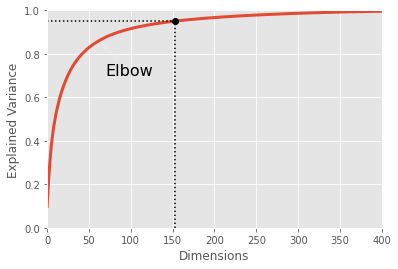

In [73]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [75]:
pca.n_components_

153

In [76]:
np.sum(pca.explained_variance_ratio_)

0.9500720180476262

In [89]:

import datetime
start=datetime.datetime.now()
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
end=datetime.datetime.now()
print(f"Training took {end-start} seconds")

## 4.7 seconds!! (10-29, 7:15am, cst)

In [92]:
type(X_reduced)

numpy.ndarray

In [80]:
X_red_df = pd.DataFrame(X_reduced)
X_red_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153
0,-556.566128,508.278371,-38.122741,-423.111465,-221.503014,152.222320,481.932685,264.281347,83.907256,93.602334,-386.124349,336.338601,64.963165,-132.894720,2.421220,53.525615,-51.894126,-262.939665,469.588355,229.454475,-347.876402,75.800540,-21.017708,-130.272745,-132.700157,-93.762272,125.252104,-73.964091,273.278225,59.837055,63.363605,187.816541,198.461730,-15.313637,162.946030,-132.308428,115.233537,170.721991,53.099229,75.617444,189.275787,-47.303610,-82.238181,-37.879818,168.177042,19.834552,-89.642733,193.327664,-22.981170,105.628928,201.129489,21.329505,15.809104,-23.487262,-55.538186,-30.776818,100.687937,187.595126,34.245226,68.640175,-15.975717,32.665524,70.870330,7.351565,-59.664292,53.893401,50.178547,22.582143,-31.495193,-2.157596,-43.194809,192.244051,-56.574487,-25.611124,38.937767,-75.975548,50.497099,-70.608778,-87.501656,-47.739635,-41.403020,27.957027,37.940592,24.842727,-30.016537,112.145126,-47.183948,-9.155546,45.814743,-60.798407,-15.090366,62.533448,16.218635,36.992481,41.986701,14.694995,-40.265233,-53.214953,-117.273577,-5.102949,-56.034717,-24.579073,4.749864,21.801168,40.973623,-6.975876,25.758630,-25.551496,-66.190450,23.184821,-3.357476,-35.456254,13.167866,55.594471,45.997901,-9.283564,-17.009344,-38.323427,3.308643,39.260997,16.013708,-105.714441,73.403189,77.221239,-31.630694,-3.564756,-52.968354,-75.863001,-52.766965,-59.962154,-17.543560,-40.512420,15.465752,-21.821776,52.285706,9.851521,9.076508,-41.823490,-21.732636,-35.495911,-70.154759,-47.119326,5.148057,-4.175870,3.759409,-13.832002,-71.730459,-32.708863,29.535422,-12.009003,-0.710240,6.952067,-51.563455,-11.409237
1,-411.026130,12.542716,-634.470067,25.003775,377.419551,-7.655857,155.226452,-282.927673,-32.668917,75.586670,-37.156346,259.326257,326.471402,257.184046,-188.254414,296.711850,-430.582855,-70.416696,-237.633412,-229.086929,-473.746331,208.906621,61.514171,163.951477,-13.443481,-176.397470,182.184166,74.500110,107.122024,-62.368006,-240.186980,155.976788,70.532899,97.856280,-257.691209,5.400739,-87.820159,2.624530,-120.767246,-107.631742,88.677821,-81.048175,-53.690749,-135.041584,-243.899157,-149.231636,-74.476862,26.645864,-1.726492,134.071906,-18.980783,-153.169847,171.573466,16.013649,-79.192495,90.322839,-19.896369,112.906122,121.779318,116.816632,86.608338,8.898411,-160.679825,169.573172,-104.617302,-35.133369,-114.964921,67.689560,-102.370376,67.632160,-13.756288,-92.619260,-33.121824,-194.594661,-1.455631,51.975843,142.260859,82.834406,-21.499434,-78.243446,-23.403037,-224.897083,158.411370,-1.687820,144.356994,-94.472609,16.433180,-5.568823,-15.877939,62.874985,29.344880,-31.180614,-107.694734,10.553782,-61.366642,2.110392,7.959136,64.290149,40.861991,56.628826,-38.316700,-102.807166,52.754618,-93.455240,7.923409,-46.050305,-18.321373,15.728681,54.343790,3.261151,35.486902,84.977332,53.286896,52.984833,64.992230,-6.092780,95.048154,-35.406013,-23.880484,-18.527611,-14.223992,76.280511,8.763161,29.951256,-58.074562,49.864323,-8.196536,52.539378,-34.870408,-32.839575,-18.046184,-37.685087,71.599873,-18.038861,17.505706,31.813866,60.161137,-34.493429,36.878771,-53.802810,-16.902917,2.776494,32.629970,6.852754,-52.764515,-1.330439,15.205594,-42.694324,31.083699,30.991159,-31.630268,21.964796,9.009524,18.066707
2,334.621214,-88.509572,-464.942369,122.063510,370.228295,-268.928358,-285.674602,-476.529818,-248.689287,-75.757031,-117.524810,-173.356318,-305.024875,55.455013,23.855246,415.527493,289.516658,-55.718315,-39.92

# **RF on PCA**

In [83]:
##start=datetime.datetime.now()
##rnd_clf.fit(X_reduced, y_train)
##rf2.fit(trainimages,labels)
##end=datetime.datetime.now()
##print(end-start)

import datetime
start=datetime.datetime.now()
grid_search_cv.fit(X_reduced, y_train)
##rf2.fit(trainimages,labels)
end=datetime.datetime.now()
print(end-start)
## 11 minutes!!

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 11.2min finished


0:11:23.058132


In [94]:
test_reduced = pca.transform(test)

In [95]:
y_pred = grid_search_cv.predict(test_reduced)

In [98]:
# Create a dataframe for results to be submitted 
pca_tree_results = pd.DataFrame(columns=['ImageID'])
pca_tree_results['ImageID'] = ImageID
pca_tree_results['Label'] = y_pred
pca_tree_results.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [102]:
pca_tree_results.iloc[-1,0]

28000

In [103]:
from datetime import datetime
date = str(datetime.now().strftime("%Y_%m_%d-%I.%M%p"))
filename=(f"pca_tree_predict_{date}.csv")
pca_tree_results.to_csv(filename, index=False)

# **k-means clustering**